## Data prep


In [18]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


rates_data = pd.read_json('rates_history.json')
rates_data.head()

,address,name,symbol,decimals,data
0,0xf9a98a9452485ed55cd3ce5260c2b71c9807b11a,ERC4626-Wrapped Lido stETH,wlstETH,18,"{'timestamp': 1666945844, 'apr': {'1d': '5.788..."
1,0xf9a98a9452485ed55cd3ce5260c2b71c9807b11a,ERC4626-Wrapped Lido stETH,wlstETH,18,"{'timestamp': 1667032466, 'apr': {'1d': '5.424..."
2,0xf9a98a9452485ed55cd3ce5260c2b71c9807b11a,ERC4626-Wrapped Lido stETH,wlstETH,18,"{'timestamp': 1667119088, 'apr': {'1d': '5.351..."
3,0xf9a98a9452485ed55cd3ce5260c2b71c9807b11a,ERC4626-Wrapped Lido stETH,wlstETH,18,"{'timestamp': 1667205710, 'apr': {'1d': '5.351..."
4,0xf9a98a9452485ed55cd3ce5260c2b71c9807b11a,ERC4626-Wrapped Lido stETH,wlstETH,18,"{'timestamp': 1667292332, 'apr': {'1d': '5.024..."


In [26]:
# we collect csv from urL: https://query1.finance.yahoo.com/v7/finance/download/%5EVIX?period1=1666705884&period2=1698241884&interval=1d&events=history&includeAdjustedClose=true
# and load into dataframe

import requests
import io
url = "https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv"
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df.head()


,DATE,OPEN,HIGH,LOW,CLOSE
0,01/02/1990,17.24,17.24,17.24,17.24
1,01/03/1990,18.19,18.19,18.19,18.19
2,01/04/1990,19.22,19.22,19.22,19.22
3,01/05/1990,20.11,20.11,20.11,20.11
4,01/08/1990,20.26,20.26,20.26,20.26


In [29]:
vix_df = df[['DATE', 'CLOSE']]
vix_df['DATE'] = pd.to_datetime(vix_df['DATE'])
vix_df.rename(columns={'CLOSE': 'VIX'}, inplace=True)
vix_df.rename(columns={'DATE': 'date'}, inplace=True)
vix_df['VIX'] = vix_df['VIX'].astype(float)
vix_df.head()

C:\Users\jordi\AppData\Local\Temp\ipykernel_38056\3285375690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_df['DATE'] = pd.to_datetime(vix_df['DATE'])
C:\Users\jordi\AppData\Local\Temp\ipykernel_38056\3285375690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_df.rename(columns={'CLOSE': 'VIX'}, inplace=True)
C:\Users\jordi\AppData\Local\Temp\ipykernel_38056\3285375690.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,date,VIX
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


<Axes: title={'center': 'Historical VIX'}, xlabel='date'>

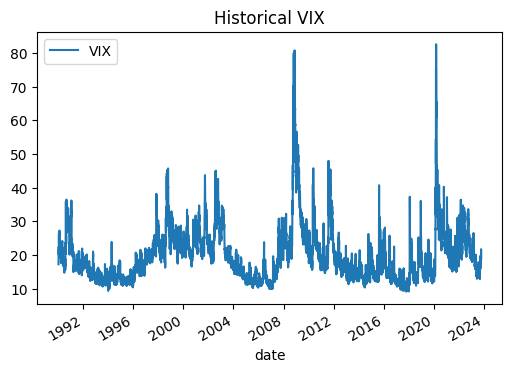

In [32]:

vix_df.plot(x='date', y='VIX', kind='line', figsize=(6,4), title='Historical VIX')


We create a time series for the historical rate of change of the series, and check it's distribution

C:\Users\jordi\AppData\Local\Temp\ipykernel_38056\1717829250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_df['change_rate'] = vix_df['VIX'].pct_change()


<Axes: title={'center': 'Wrapped Lido stETH - APR 30d - Change Rate'}, xlabel='date'>

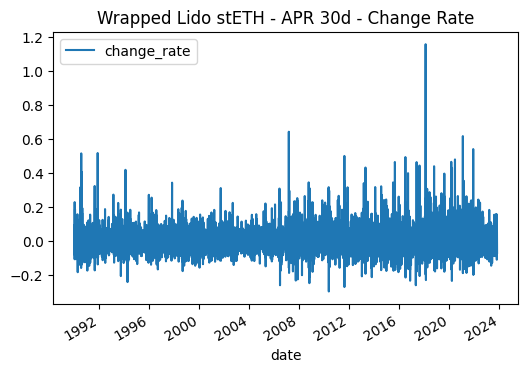

In [34]:
vix_df['change_rate'] = vix_df['VIX'].pct_change()
vix_df.plot(x='date', y='change_rate', kind='line', figsize=(6,4), title='VIX rate change')


<Axes: title={'center': 'Density Plot for VIX Change Rate'}, ylabel='Density'>

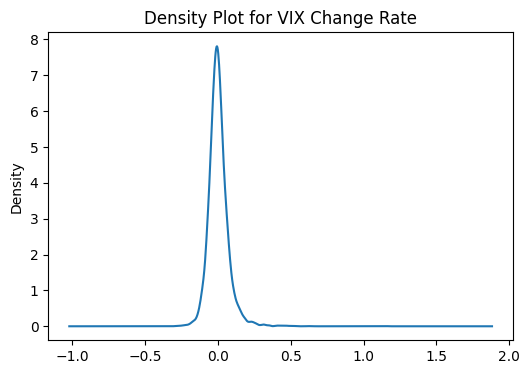

In [36]:
vix_df['change_rate'].plot(kind='density', figsize=(6,4),title='Density Plot for VIX Change Rate')

   change_rate       CDF
0    -0.295726  0.000117
1    -0.269583  0.000235
2    -0.259087  0.000352
3    -0.259057  0.000469
4    -0.246836  0.000587


<Axes: title={'center': 'CDF Plot for VIX Change Rate'}, xlabel='change_rate'>

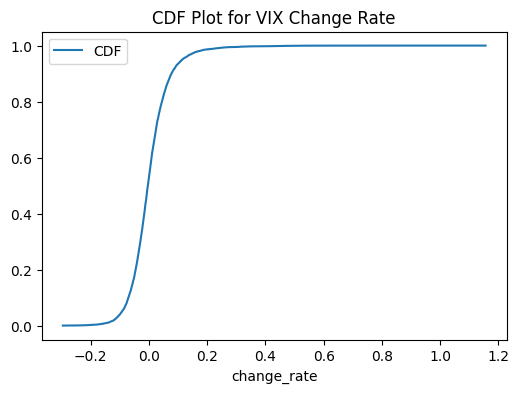

In [38]:
cdf = vix_df['change_rate'].value_counts(normalize=True).sort_index().cumsum()
cdf_df = pd.DataFrame({'change_rate': cdf.index, 'CDF': cdf.values})
print(cdf_df.head())
cdf_df.plot(x='change_rate', y='CDF', kind='line', figsize=(6,4), title='CDF Plot for VIX Change Rate')


## Random path generation


In [39]:
# Generate a random number between 0 and 1, use it to get the closest change rate from the CDF (which goes from 0 to 1), to produce a synthetic PDF 
def get_random_sample(cdf_df):
    random_sample = np.random.uniform()
    closest_cdf_index = np.abs(cdf_df['CDF'] - random_sample).idxmin()
    closest_change_rate = cdf_df.loc[closest_cdf_index, 'change_rate']
    return closest_change_rate
get_random_sample(cdf_df)


-0.021114864864864913

In [40]:
def build_random_path(start,length,num_paths,cdf_df):
    random_paths = []
    for i in range(num_paths):
        random_path = []
        for j in range(length):
            if j == 0:
                random_path.append(start)
            else:
                # last item in the random_path list
                last_change_rate = random_path[-1]
                random_change = get_random_sample(cdf_df)
                new_value = last_change_rate*(1+ random_change)
                random_path.append(new_value)
        random_paths.append(random_path)
    return pd.DataFrame(random_paths).transpose()

# sample use
random_df = build_random_path(0.05,360,5,cdf_df)
random_df['date'] = vix_df['date']
print(random_df.head())

          0         1         2         3         4       date
0  0.050000  0.050000  0.050000  0.050000  0.050000 1990-01-02
1  0.054701  0.048559  0.049459  0.052543  0.049157 1990-01-03
2  0.048988  0.049658  0.054440  0.056343  0.056447 1990-01-04
3  0.048872  0.048708  0.051373  0.055560  0.053628 1990-01-05
4  0.049183  0.048783  0.050998  0.054764  0.054132 1990-01-08


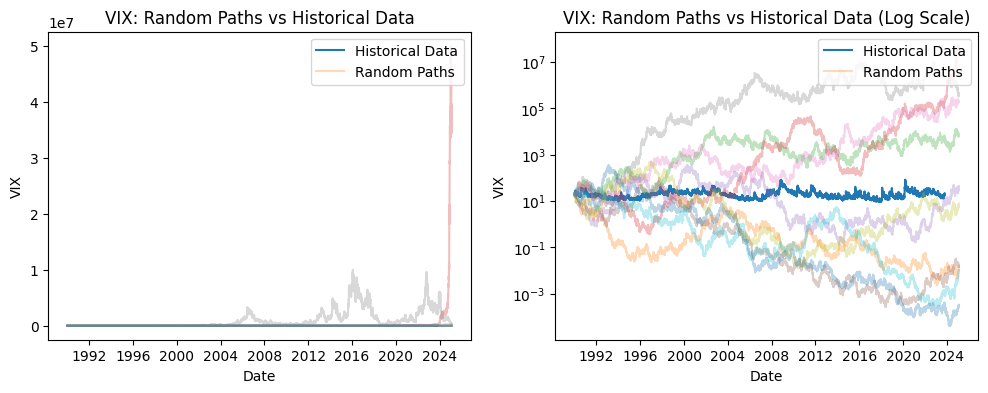

In [56]:
num_paths = 10
starting_rate = 20
path_length = 9000
random_df = build_random_path(starting_rate,path_length,num_paths,cdf_df)

# we create dates for the random paths beyond the historical data
date_col_list = vix_df['date'].tolist()
while len(date_col_list) < len(random_df):
    last_date = pd.to_datetime(date_col_list[-1])
    next_date = last_date + pd.DateOffset(days=1)
    date_col_list.append(next_date)
date_col = pd.DataFrame(date_col_list, columns=['date'])
random_df['date'] = date_col['date']

# plotting
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# plot 1: regular scale
axs[0].plot(vix_df['date'], vix_df['VIX'], label='Historical Data')
for col in range(num_paths):
    if col > 0:
        axs[0].plot(random_df['date'],random_df[col],  alpha=0.3)
    else:
        axs[0].plot(random_df['date'],random_df[col], label='Random Paths',  alpha=0.3)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('VIX')
axs[0].set_title('VIX: Random Paths vs Historical Data')
axs[0].legend(loc='upper right')

# plot 2: log scale
axs[1].plot(vix_df['date'], vix_df['VIX'], label='Historical Data')
for col in range(num_paths):
    if col > 0:
        axs[1].plot(random_df['date'],random_df[col],  alpha=0.3)
    else:
        axs[1].plot(random_df['date'],random_df[col], label='Random Paths',  alpha=0.3)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('VIX')
axs[1].set_title('VIX: Random Paths vs Historical Data (Log Scale)')
axs[1].legend(loc='upper right')
axs[1].set_yscale('log')

plt.show()

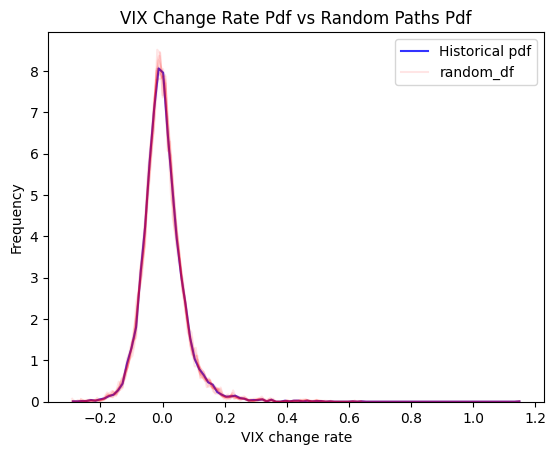

In [52]:
# create the histogram manually for historical data just to get the bins and values and hide it
n, bins, patches = plt.hist(vix_df['VIX'].pct_change(), bins=100, alpha=0, color='blue',  density=True)
# we display the histogram as a line chart, not bars
bin_centers = 0.5*(bins[1:] + bins[:-1])
plt.plot(bin_centers, n, color='blue', alpha=0.8, label='Historical pdf')

# create the histograms for random_df
for i, col in enumerate(random_df.columns):
    if col != 'date':
        n, bins, patches = plt.hist(random_df[col].pct_change(), bins=100, alpha=0, color='red', density=True)
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        plt.plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)

# add labels and title
plt.xlabel('VIX change rate')
plt.ylabel('Frequency')
plt.title('VIX Change Rate Pdf vs Random Paths Pdf')
plt.legend()
plt.show()


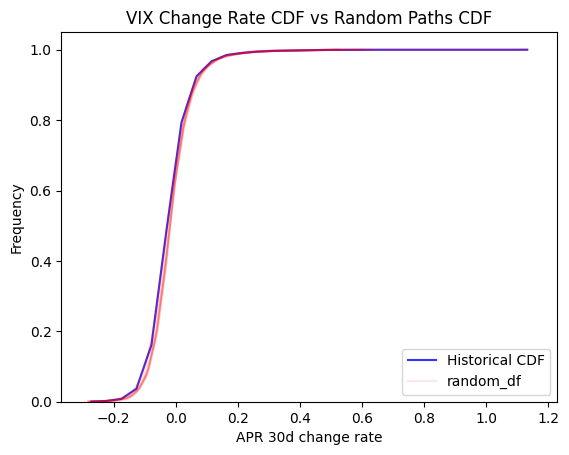

In [58]:
# we also create the CDF manually for historical data just to get the bins and values
n, bins, patches = plt.hist(vix_df['VIX'].pct_change(), bins=30, alpha=0, color='blue',  density=True, cumulative=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
plt.plot(bin_centers, n, color='blue', alpha=0.8, label='Historical CDF')

# create the CDF for random_df
for i, col in enumerate(random_df.columns):
    if col != 'date':
        n, bins, patches = plt.hist(random_df[col].pct_change(), bins=30, alpha=0, color='red', density=True, cumulative=True)
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        plt.plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)

# add labels and title
plt.xlabel('APR 30d change rate')
plt.ylabel('Frequency')
plt.title('VIX Change Rate CDF vs Random Paths CDF')
plt.legend()
plt.show()
